In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings

from cartopy.util import add_cyclic_point

from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
import os
import cartopy.crs as ccrs
import jobs.theory_lapse.cesm.thesis_figs.scripts.utils as utils
from tqdm.notebook import tqdm
from isca_tools.thesis.lapse_integral import integral_and_error_calc
from isca_tools.thesis.lapse_integral_simple import get_temp_2_layer_approx
from isca_tools.thesis.mod_parcel_theory import get_temp_mod_parcel
from isca_tools.utils.constants import lapse_dry
from isca_tools.cesm import get_pressure
from isca_tools.utils.constants import g, R, lapse_dry, temp_kelvin_to_celsius
from isca_tools.utils.ds_slicing import fold_coarsen

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Formatting figures info
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']
leg_handlelength = 1.5

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [97]:
%%time
p_ft_use = 400 * 100
co2_vals = xr.DataArray([1, 2], dims="co2", name='co2')
ds = {'quant50': [], 'quant95': []}
ds_quant95 = []
with tqdm(total=len(utils.exp_names) * 2, position=0, leave=True) as pbar:
    for exp_name in utils.exp_names:
        ds['quant50'].append(utils.load_ds(exp_name, 50, var_keep=utils.vars_lapse_data+['time', 'FREQZM']).sel(p_ft=p_ft_use).load())
        pbar.update(1)
        ds['quant95'].append(utils.load_ds(exp_name, 95, var_keep=utils.vars_lapse_data+['time', 'FREQZM']).sel(p_ft=p_ft_use, lat=ds['quant50'][-1].lat).load())
        pbar.update(1)
for key in ds:
    ds[key] = xr.concat(ds[key], dim=co2_vals)
    ds[key] = utils.sel_best_rh_mod(ds[key])

lat_weights = utils.lat_weights.reindex_like(ds['quant50'].lat)
temp_surf_lcl_calc = ds['quant50'].temp_surf_lcl_calc
p_ft = float(ds['quant50'].p_ft)
lsm = ds['quant50'].LANDFRAC.isel(co2=0) > utils.land_frac_thresh
ocean_mask = ds['quant50'].LANDFRAC.isel(co2=0) == 0

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 1min 15s, sys: 18.8 s, total: 1min 33s
Wall time: 2min 19s


In [98]:
# FT anomaly from zonal mean on that day
temp_ft_zm = xr.concat([xr.load_dataset(os.path.join(utils.out_dir, f"ds_t400_climatology_{exp_name}.nc"))
                        for exp_name in utils.exp_names], dim=co2_vals).sel(lat=ds['quant50'].lat).T
for key in ds:
    ds[key]['T_ft_env_zm'] = temp_ft_zm.sel(dayofyear=ds[key].time.dt.dayofyear)
    ds[key]['T_ft_env_anom'] = ds[key].T_ft_env - ds[key]['T_ft_env_zm']
    ds[key] = ds[key].squeeze()

In [99]:
# Get rid of variables no longer need. Must remove those without atleast lon, lat, sample in dimensions for fold_coarsen to work
drop_vars = ['hyam', 'hybm', 'lnb1_ind', 'LANDFRAC', 'const_rh_mod_ind', 'mod_parcel_rh_mod_ind', 'lapse_Dz',
             'lapse_Mz', 'layer', 'time']
for key in ['parcel', 'const', 'mod_parcel']:
    for key2 in ['lapse', 'integral', 'error']:
        drop_vars.append(f"{key}_{key2}")
for key in ds:
    ds[key]['p_lnb_approx'] = get_pressure(ds[key].PS, ds[key].P0, ds[key].hyam, ds[key].hybm).isel(
        lev=ds[key].lnb1_ind)
    ds[key]['lapse_Dz'] = ds[key].mod_parcel_lapse.isel(layer=0) / 1000 - lapse_dry
    ds[key]['lapse_Mz'] = ds[key].mod_parcel_lapse.isel(layer=1) / 1000
    ds[key]['lapse_D'] = R / g * ds[key].TREFHT * ds[key]['lapse_Dz']
    ds[key]['lapse_M'] = R / g * ds[key].T_ft_env * ds[key]['lapse_Mz']
    ds[key]['mod_parcel_rh_mod'] = ds[key].rh_mod[ds[key].mod_parcel_rh_mod_ind]
    ds[key] = ds[key].drop_vars('rh_mod')
    ds[key] = ds[key].rename_vars({'mod_parcel_rh_mod': 'rh_mod'})

    ds[key]['mask_conv'] = utils.get_valid_mask(ds[key]) & (ds[key].TREFHT > temp_kelvin_to_celsius)
    ds[key]['lsm'] = (ds[key].TREFHT > 0).isel(co2=0) & lsm  # so lsm has sample dimension required for coarsening
    ds[key]['ocean_mask'] = (ds[key].TREFHT > 0).isel(
        co2=0) & ocean_mask  # so mask has sample dimension required for coarsening
    ds[key]['lat_weights'] = lat_weights.where((ds[key].TREFHT > 0).isel(co2=0))
    ds[key] = ds[key].drop_vars(drop_vars)

## Coarsen Grid
Below, I coarsen grid, and then consider regions for which there are atleast 50 valid days at that new larger grid point.
There is still a significant number of regions to do subsequent analysis.

Do that here so in convection point can indicate locations included.

In [100]:
n_coarse_lat = 3
n_coarse_lon = 4
ds_coarse = {key: fold_coarsen(ds[key], k_lat=n_coarse_lat, k_lon=n_coarse_lon) for key in ds}
n_conv_day_thresh = {'quant50': 400 * 10,
                     'quant95': 400}  # require atleast this many convective days (about 1/3) to plot
for key in ds_coarse:
    ds_coarse[key]['mask_conv_land'] = ds_coarse[key]['mask_conv'] & ds_coarse[key]['lsm']
    ds_coarse[key]['mask_conv_ocean'] = ds_coarse[key]['mask_conv'] & ds_coarse[key]['ocean_mask']
mask_loc_land = {key: ds_coarse[key]['mask_conv_land'].sum(dim='sample').min(dim='co2') > n_conv_day_thresh[key] for key
                 in ds_coarse}
mask_loc_land = mask_loc_land['quant50'] & mask_loc_land['quant95']
mask_loc_ocean = {key: ds_coarse[key]['mask_conv_ocean'].sum(dim='sample').min(dim='co2') > n_conv_day_thresh[key] for
                  key in ds_coarse}
mask_loc_ocean = mask_loc_ocean['quant50'] & mask_loc_ocean['quant95']
if not np.sum(mask_loc_land & mask_loc_ocean).values == 0:
    # Sanity check
    raise ValueError('Overlap of ocean and land masks')

In [116]:
# Average over convective days in valid regions
ds_av = []
for key in ds_coarse:
    # For land, use all convective days in valid land coordinates
    # For ocean, use all convective days in valid ocean coordinates
    # No overlap of these masks hence use of `or` below
    mask_use = (ds_coarse[key]['mask_conv_land'] & mask_loc_land) | (ds_coarse[key]['mask_conv_ocean'] & mask_loc_ocean)
    ds_av.append(ds_coarse[key].where(mask_use).weighted(ds_coarse[key].lat_weights).mean(dim='sample'))
    ds_av[-1]['n_conv_days'] = mask_use.sum(dim='sample')
    ds_av[-1]['FREQZM_frac'] = (ds_coarse[key].where(mask_use).FREQZM>0).sum(dim='sample') / ds_av[-1]['n_conv_days']

quant_vals = xr.DataArray([50, 95], dims="quant", name='quant')
ds_av = xr.concat(ds_av, dim=quant_vals)
ds_av = ds_av.transpose('co2', 'quant', 'lat', 'lon')

### Scaling factor for all vs just convective days
Theoretically, the convective days for x>50 could just be the hottest so the scaling factor using convective days may not represent the scaling factor for all days. I compare the two below.

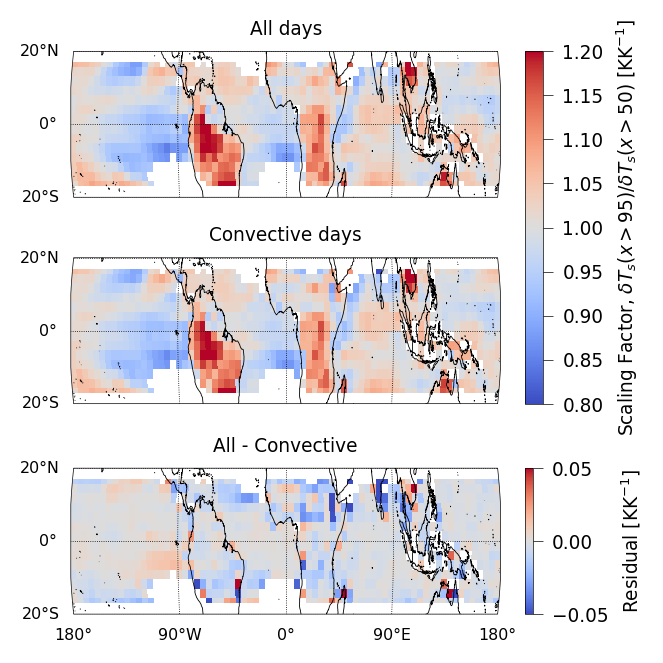

In [102]:
thresh_residual_diff = 0.05  # mask out region where deviation in scaling factors more than this fraction
sf_label = utils.sf_label.replace('(x)', '(x>95)').replace('\overline{T}_s', 'T_s(x>50)')

gl_fontsize = 5.74  # sets gridlines font - update_fontsize() does no change it
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0.1, 'wspace': 0})
# fig_resize(fig, 10, ar=5)
fig_resize(fig, width['one_col'], ar=3)
# for ax_use in ax.flatten():
#     ax_use.set_aspect('auto')
#     ax_use.set_extent([-180, 180, -20, 20], crs=ccrs.PlateCarree())
#     ax_use.coastlines()
for i in range(len(ax)):
    # Aspect='auto crucial to keep axes looking good throughout
    gl = utils.initialize_ax_projection(ax[i], lat_min=-20.01, lat_max=20.01, auto_aspect=True,
                                        gridline_lw=0.3, coastline_lw=0.3, grid_lat=[-20, 0, 20],
                                        grid_lon=[-180, -90, 0, 90, 180], return_gl=True)[1]
    if i < 2:
        gl.bottom_labels = False
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}

var = [ds_coarse['quant95'].TREFHT.mean(dim='sample').diff(dim='co2').squeeze() /
       ds_coarse['quant50'].TREFHT.mean(dim='sample').diff(dim='co2').squeeze(),
       ds_av.isel(quant=1).TREFHT.diff(dim='co2').squeeze() / ds_av.isel(quant=0).TREFHT.diff(dim='co2').squeeze()]
for i in range(len(var)):
    im = utils.plot_contour_projection(ax[i], var[i].where(mask_loc_land | mask_loc_ocean), cmap='coolwarm',
                                       imshow=True, imshow_kwargs={'vmin': 0.8, 'vmax': 1.2, 'aspect': 'auto'})
plt.colorbar(im, ax=ax[:2].ravel(), label=sf_label, pad=0.02)

im = utils.plot_contour_projection(ax[2], (var[1] - var[0]).where(mask_loc_land | mask_loc_ocean),
                                   cmap='coolwarm', imshow=True,
                                   imshow_kwargs={'vmin': -0.05, 'vmax': 0.05, 'aspect': 'auto'})
plt.colorbar(im, ax=ax[2:].ravel(), label='Residual [KK$^{-1}$]', pad=0.02)
ax[0].set_title('All days')
ax[1].set_title('Convective days')
ax[2].set_title('All - Convective')
update_fontsize(fig)
plt.show()
# savefig(fig)

# Only keep regions going foreward where less than 5% scaling factor difference in all vs convective days
mask_residual_diff = (np.abs(var[1] - var[0]) / var[0]) < thresh_residual_diff
mask_loc = (mask_loc_ocean | mask_loc_land) & mask_residual_diff

In [103]:
# Print info on how much of the tropics removed by each condition
print(((mask_loc_ocean | mask_loc_land)==0).sum().values)
print((mask_residual_diff.where((mask_loc_ocean | mask_loc_land))==0).sum().values)
print(mask_loc.sum().values)
print(mask_loc.sum().values/np.prod(mask_loc.shape)*100)

109
12
887
87.99603174603175


In [104]:
# Compute reference day which is a perfect parcel at quant>50 av surface conditions in preindustrial climate
ds_ref = ds_av.sel(quant=50)

# So ref is parcel
ds_ref['lapse_M'] = ds_ref['lapse_M'] * 0
ds_ref['lapse_D'] = ds_ref['lapse_D'] * 0
ds_ref['rh_mod'] = ds_ref['rh_mod'] * 0

# So ref does not change relative humidity or pressure
ds_ref['rh_REFHT'] = ds_ref.rh_REFHT * 0 + ds_ref.rh_REFHT.isel(co2=0)
ds_ref['PREFHT'] = ds_ref.PREFHT * 0 + ds_ref.PREFHT.isel(co2=0)
# Set reference FT temperature to that following a parcel profile
ds_ref['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_ref.rh_REFHT + ds_ref.rh_mod,
                                    ds_ref.PREFHT,
                                    p_ft, 0, 0, ds_ref['TREFHT'],
                                    input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                    kwargs={'temp_surf_lcl_calc': temp_surf_lcl_calc})

### Scaling factor breakdown
Below I compute the scaling factor contribution at each location for why x>95 warms differently to x>50

In [105]:
comp_level = 4
out_path_sf = os.path.join(utils.out_dir, 'ds_tropics_sf_spatial.nc')
out_path_sf_num = os.path.join(utils.out_dir, 'ds_tropics_sf_spatial_num.nc')
if os.path.exists(out_path_sf):
    ds_sf = xr.load_dataset(out_path_sf).squeeze()
    print(f'Loaded ds_sf from {out_path_sf}')
else:
    ds_sf = []
if os.path.exists(out_path_sf_num):
    ds_sf_num = xr.load_dataset(out_path_sf_num).squeeze()
    print(f'Loaded ds_sf_num from {out_path_sf_num}')
else:
    ds_sf_num = []

with tqdm(total=ds_av.lat.size * ds_av.lon.size, position=0, leave=True) as pbar:
    for i in range(ds_av.lat.size):
        ds_sf_lat = []
        ds_sf_num_lat = []
        for j in range(ds_av.lon.size):
            if isinstance(ds_sf, list):
                ds_sf_lat.append(
                    utils.apply_sf_theory_with_rh_mod(ds_av.isel(lat=i, lon=j),
                                                      ds_ref.isel(lat=i, lon=j),
                                                      p_ft, temp_surf_lcl_calc, quant_dim='quant', numerical=False))
            if isinstance(ds_sf_num, list):
                ds_sf_num_lat.append(
                    utils.apply_sf_theory_with_rh_mod(ds_av.isel(lat=i, lon=j),
                                                      ds_ref.isel(lat=i, lon=j),
                                                      p_ft, temp_surf_lcl_calc, quant_dim='quant', numerical=True))
            pbar.update(1)
        if isinstance(ds_sf, list):
            ds_sf.append(xr.concat(ds_sf_lat, dim=ds_av.lon))
        if isinstance(ds_sf_num, list):
            ds_sf_num.append(xr.concat(ds_sf_num_lat, dim=ds_av.lon))

if isinstance(ds_sf, list):
    ds_sf = xr.concat(ds_sf, dim=ds_av.lat).squeeze()
    ds_sf.to_netcdf(out_path_sf, encoding={var: {"zlib": True, "complevel": comp_level} for var in ds_sf.data_vars})
    print(f'Saved ds_sf to {out_path_sf}')
if isinstance(ds_sf_num, list):
    ds_sf_num = xr.concat(ds_sf_num, dim=ds_av.lat).squeeze()
    ds_sf_num.to_netcdf(out_path_sf_num,
                        encoding={var: {"zlib": True, "complevel": comp_level} for var in ds_sf_num.data_vars})
    print(f'Saved ds_sf_num to {out_path_sf}')

Loaded ds_sf from /Users/joshduffield/Documents/StAndrews/Isca/jobs/theory_lapse/cesm/thesis_figs/ds_processed/ds_tropics_sf_spatial.nc
Loaded ds_sf_num from /Users/joshduffield/Documents/StAndrews/Isca/jobs/theory_lapse/cesm/thesis_figs/ds_processed/ds_tropics_sf_spatial_num.nc


  0%|          | 0/1008 [00:00<?, ?it/s]

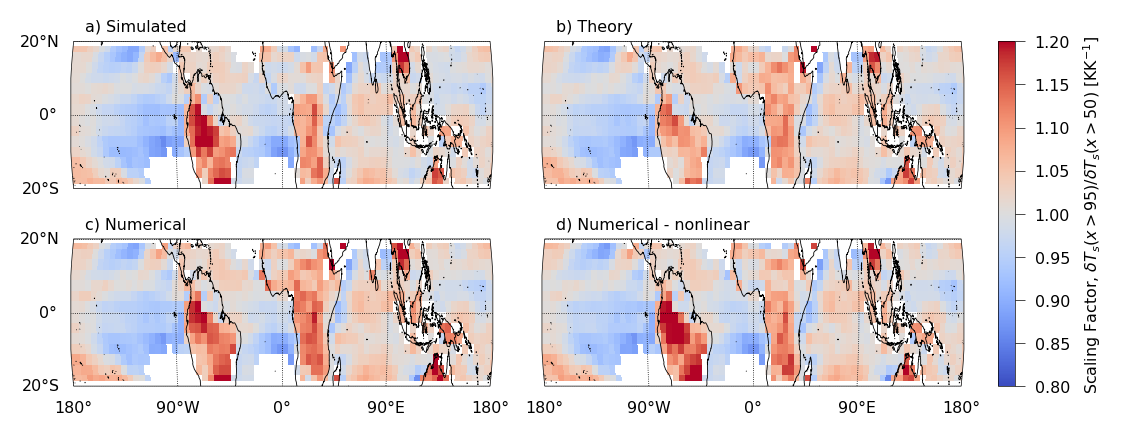

In [106]:
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0.1, 'wspace': 0})
# fig_resize(fig, 10, ar=5)
fig_resize(fig, width['two_col'])
for i in range(len(ax.flatten())):
    # Aspect='auto crucial to keep axes looking good throughout
    gl = utils.initialize_ax_projection(ax.flatten()[i], lat_min=-20.01, lat_max=20.01, auto_aspect=True,
                                        gridline_lw=0.3, coastline_lw=0.3, grid_lat=[-20, 0, 20],
                                        grid_lon=[-180, -90, 0, 90, 180], return_gl=True)[1]
    if i < 2:
        gl.bottom_labels = False
    if i % 2:
        gl.left_labels = False
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}

var = ds_sf_num.scale_factor_linear + ds_sf_num.nl_rh_change_rh_anom + ds_sf_num.nl_temp_surf_anom_rh_anom - 2
im = utils.plot_contour_projection(ax[0, 0], ds_sf.scale_factor.isel(quant=1).where(mask_loc), cmap='coolwarm',
                                   imshow=True, imshow_kwargs={'vmin': 0.8, 'vmax': 1.2, 'aspect': 'auto',
                                                               'extent': (0, 360, -20, 20)})
im = utils.plot_contour_projection(ax[0, 1], ds_sf.scale_factor_sum.diff(dim='quant').squeeze().where(mask_loc) + 1,
                                   cmap='coolwarm',
                                   imshow=True, imshow_kwargs={'vmin': 0.8, 'vmax': 1.2, 'aspect': 'auto',
                                                               'extent': (0, 360, -20, 20)})
im = utils.plot_contour_projection(ax[1, 0],
                                   ds_sf_num.scale_factor_linear.diff(dim='quant').squeeze().where(mask_loc) + 1,
                                   cmap='coolwarm',
                                   imshow=True, imshow_kwargs={'vmin': 0.8, 'vmax': 1.2, 'aspect': 'auto',
                                                               'extent': (0, 360, -20, 20)})
im = utils.plot_contour_projection(ax[1, 1], (var.diff(dim='quant') + 1).squeeze().where(mask_loc), cmap='coolwarm',
                                   imshow=True, imshow_kwargs={'vmin': 0.8, 'vmax': 1.2, 'aspect': 'auto',
                                                               'extent': (0, 360, -20, 20)})

plt.colorbar(im, ax=ax.flatten().ravel(), label=sf_label, pad=0.02)

# ax[0].set_title('All days')
# ax[1].set_title('Convective days')
# ax[2].set_title('All - Convective')
label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=8,
               labels=[f'a) Simulated', f'b) Theory',
                       f'c) Numerical', f'd) Numerical - nonlinear'])
update_fontsize(fig)
plt.show()
# savefig(fig)

### Contribution from each mechanism
Below I show the individual contribution from each mechanism (using thoeretical not numerical estimate). I then indicate where non linear important with dot markers. The cross marker in hot-get-hotter plot is where non linear hot-get-hotter and drier-get-hotter give cooling effect. The crosses in the drier-get-hotter plot are where modified rh anomaly important.

In [107]:
use_numerical = False
if use_numerical:
    ds_sf_use = ds_sf_num.diff(dim='quant').squeeze() + 1
    # in numerical, combined mod and physical rh. Here, lets separate them again
    ds_sf_use['rh_mod_change'] = ds_sf['rh_mod_change'].diff(dim='quant').squeeze() + 1
    ds_sf_use['rh_change'] = ds_sf_use['rh_change'].diff(dim='quant').squeeze() - ds_sf_use['rh_mod_change'].diff(dim='quant').squeeze() + 1
    ds_sf_use['rh_mod_anom'] = ds_sf['rh_mod_anom'].diff(dim='quant').squeeze() + 1
    ds_sf_use['rh_anom'] = ds_sf_use['rh_anom'].diff(dim='quant').squeeze() - ds_sf_use['rh_mod_anom'].diff(dim='quant').squeeze() + 1
    ds_sf_use['scale_factor_sum'] = ds_sf_use['scale_factor_linear'].diff(dim='quant').squeeze() + 1
else:
    ds_sf_use = ds_sf.diff(dim='quant').squeeze() + 1
    # Note that below term is nonlinear (rh + rh_mod) with (rh_anom + rh_mod_anom)
    ds_sf_use['nl_rh_change_rh_anom'] = ds_sf_num['nl_rh_change_rh_anom'].diff(dim='quant').squeeze() + 1
    ds_sf_use['nl_temp_surf_anom_rh_anom'] = ds_sf_num['nl_temp_surf_anom_rh_anom'].diff(dim='quant').squeeze() + 1

In [108]:
def plot_scatter_mask(mask, ax, s=12, color='k', marker='.', zorder=20, edgecolors='None', linewidths=1.0):
    # Cyclic versions of BOTH data and mask along lon axis=1
    mask_c, lon_c = add_cyclic_point(mask.values.astype(int), coord=mask["lon"].values, axis=1)  # [web:66]
    mask_c = mask_c.astype(bool)

    # Scatter where True (now indices match lon_c)
    iy, ix = np.where(mask_c)

    lon_pts = lon_c[ix]
    lat_pts = mask["lat"].values[iy]

    return ax.scatter(lon_pts, lat_pts, transform=ccrs.PlateCarree(),
                      s=s, marker=marker, facecolors=color, edgecolors=edgecolors, zorder=zorder, linewidths=linewidths)

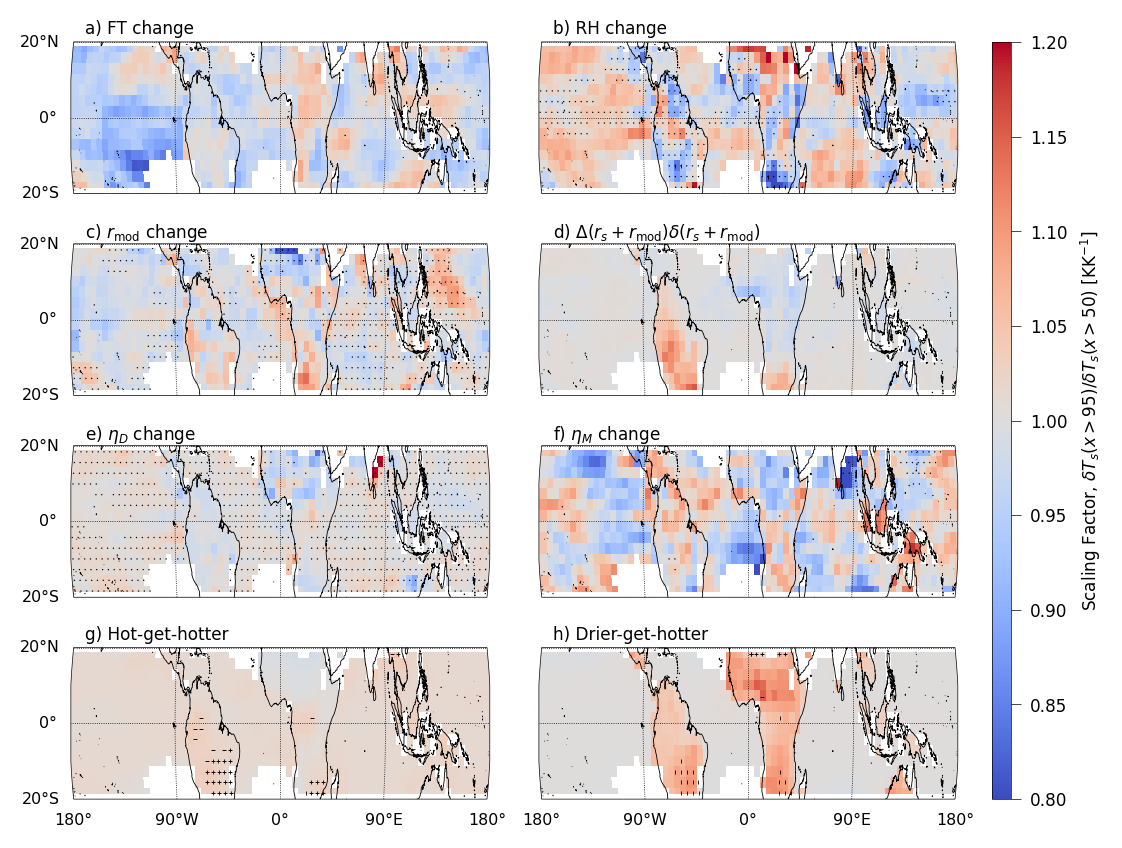

In [172]:
thresh_mask_nl = 0.03

fig = plt.figure(constrained_layout=True)
ax = fig.subplots(4, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0.1, 'wspace': 0})
fig_resize(fig, width['two_col'], ar=4 / 3 * 2)
for i in range(len(ax.flatten())):
    # Aspect='auto crucial to keep axes looking good throughout
    gl = utils.initialize_ax_projection(ax.flatten()[i], lat_min=-20.01, lat_max=20.01, auto_aspect=True,
                                        gridline_lw=0.3, coastline_lw=0.3, grid_lat=[-20, 0, 20],
                                        grid_lon=[-180, -90, 0, 90, 180], return_gl=True)[1]
    if i < 6:
        gl.bottom_labels = False
    if i % 2:
        gl.left_labels = False
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}

var_plot = ['temp_ft_change', 'rh_change', 'rh_mod_change', 'nl_rh_change_rh_anom', 'lapse_D_change', 'lapse_M_change',
            'temp_surf_anom', 'rh_anom']
labels_use = []
for key in var_plot:
    if key == 'nl_rh_change_rh_anom':
        labels_use.append(utils.style_map_cont[key][2].replace('r_s', '(r_s+r_{\\text{mod}})'))
    else:
        labels_use.append(utils.labels_cont[key])
    # if key == 'temp_surf_anom':
    #     labels_use[-1] = labels_use[-1] + f" (including {utils.style_map_cont['nl_temp_surf_anom_rh_anom'][2]})"

for i in range(len(var_plot)):
    var = ds_sf_use[var_plot[i]]
    # if key == 'temp_surf_anom':
    #     var = var + ds_sf_use['nl_temp_surf_anom_rh_anom'] - 1
    im = utils.plot_contour_projection(ax.flatten()[i], var.where(mask_loc),
                                       cmap='coolwarm', imshow=True,
                                       imshow_kwargs={'vmin': 0.8, 'vmax': 1.2, 'aspect': 'auto',
                                                      'extent': (0, 360, -20, 20)})
    if 'nl' not in var_plot[i]:
        if 'rh_mod' in var_plot[i]:
            continue
        elif var_plot[i] == 'rh_change':
            # In numerical, combine rh_mod and rh - account for this
            var = ds_sf[var_plot[i]].diff(dim='quant').squeeze() + ds_sf['rh_mod_change'].diff(dim='quant').squeeze() - \
                  ds_sf_num[var_plot[i]].diff(dim='quant').squeeze()
        elif var_plot[i] == 'rh_anom':
            # In numerical, combine rh_mod and rh - account for this
            var = ds_sf[var_plot[i]].diff(dim='quant').squeeze() + ds_sf['rh_mod_anom'].diff(dim='quant').squeeze() - \
                  ds_sf_num[var_plot[i]].diff(dim='quant').squeeze()
        else:
            var = ds_sf[var_plot[i]].diff(dim='quant').squeeze() - ds_sf_num[var_plot[i]].diff(dim='quant').squeeze()
        mask_nl_use = np.abs(var) > thresh_mask_nl
        if mask_nl_use.any():
            plot_scatter_mask(mask_nl_use & mask_loc, ax.flatten()[i], s=2, marker='|', linewidths=0.3)

# Mask where r_mod_anom important
mask_nl_use = np.abs(ds_sf['rh_mod_anom'].diff(dim='quant').squeeze()) > thresh_mask_nl
if mask_nl_use.any():
    plot_scatter_mask(mask_nl_use & mask_loc, ax.flatten()[-1], s=2, marker='_', linewidths=0.3)
# Mask where nl_rh_anom_temp_anom important
mask_nl_use = np.abs(ds_sf_num['nl_temp_surf_anom_rh_anom'].diff(dim='quant').squeeze()) > thresh_mask_nl
if mask_nl_use.any():
    plot_scatter_mask(mask_nl_use & mask_loc, ax.flatten()[-2], s=2, marker='_', linewidths=0.3)


# Show where x>50 variable decreases
mask_nl_use = ds_sf['rh_change'].isel(quant=0)>1
plot_scatter_mask(mask_nl_use & mask_loc, ax.flatten()[1], s=1, linewidths=0.3)

mask_nl_use = ds_sf['rh_mod_change'].isel(quant=0)>1
plot_scatter_mask(mask_nl_use & mask_loc, ax.flatten()[2], s=1, linewidths=0.3)

mask_nl_use = ds_sf['lapse_D_change'].isel(quant=0)<1
plot_scatter_mask(mask_nl_use & mask_loc, ax.flatten()[4], s=1, linewidths=0.3)

mask_nl_use = ds_sf['lapse_M_change'].isel(quant=0)<1
plot_scatter_mask(mask_nl_use & mask_loc, ax.flatten()[5], s=1, linewidths=0.3)

plt.colorbar(im, ax=ax.flatten().ravel(), label=sf_label, pad=0.02, fraction=0.1, aspect=40)
label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=8,
               labels=[f"{chr(ord('a') + i)}) {labels_use[i]}" for i in range(len(ax.flatten()))])
update_fontsize(fig)
plt.show()
# savefig(fig)

### Sensitivity factors
Below i plot a couple of sensitivity factors just to see if important. I think main thing is land-sea contrast, and then subtropics more sensitive due to being hotter and drier.

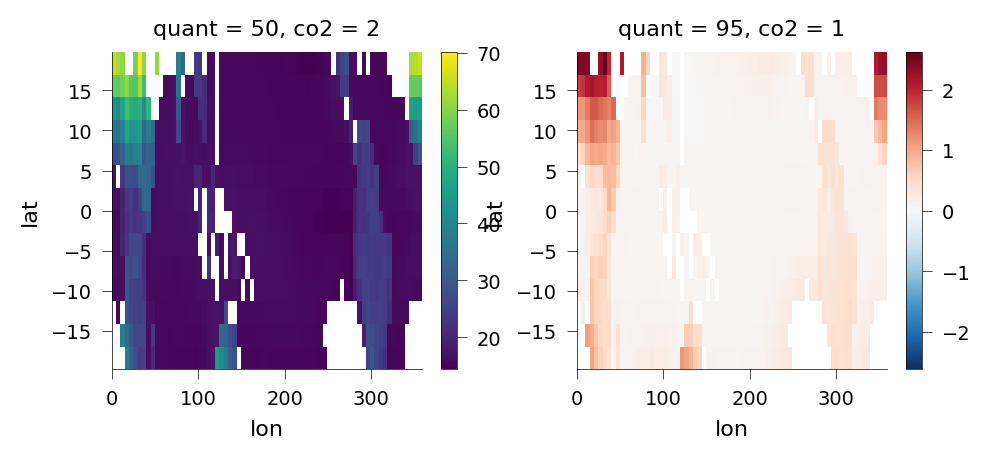

In [174]:
fig, ax = plt.subplots(1, 2)
fig_resize(fig, width['two_col'])
(-(ds_sf.rh_change.isel(quant=0)-1)*ds_av.TREFHT.isel(quant=0).diff(dim='co2')/ds_av.rh_REFHT.isel(quant=0).diff(dim='co2')).squeeze().plot(ax=ax[0])
(-(ds_sf.rh_anom.isel(quant=1)-1)/ds_av.rh_REFHT.diff(dim='quant').isel(co2=0).squeeze()).plot(ax=ax[1])

In [110]:
# Numer of days with positive lapse_M change as not clear from above
print((ds_sf['lapse_M_change']>1).sum(dim=['lat', 'lon']).values)
print((ds_sf['rh_change']<1).where(mask_loc_ocean).sum(dim=['lat', 'lon']).values/float((mask_loc&mask_loc_ocean).sum()))
print((ds_sf['rh_change']>1).where(mask_loc_land).sum(dim=['lat', 'lon']).values/float((mask_loc&mask_loc_land).sum()))

[865 836]
[0.82882883 0.67417417]
[0.6561086  0.68325792]


In [132]:
# Correlation between aloft lapse rate and relative humidity change mechanisms
for var in [mask_loc_ocean, mask_loc_land]:
    print('rh_change | lapse_M', float(xr.corr((ds_sf['lapse_M_change'].diff(dim='quant').squeeze()).where(mask_loc & var),
            (ds_sf['rh_change'].diff(dim='quant').squeeze()).where(mask_loc & var))))
    print('rh_change | FREQZM_frac', float(xr.corr((ds_av['rh_REFHT'].diff(dim='co2').diff(dim='quant').squeeze()).where(mask_loc & var),
            (ds_av['FREQZM_frac'].diff(dim='co2').diff(dim='quant').squeeze()).where(mask_loc & var))))

rh_change | lapse_M -0.4011771938912435
rh_change | FREQZM_frac 0.4371116943704279
rh_change | lapse_M -0.4940275666321975
rh_change | FREQZM_frac 0.22586537726175415


In [137]:
# Print most significant correlations in change mechanisms
for key in ds_sf:
    for key2 in ds_sf:
        if key2 == key:
            continue
        if 'change' not in key:
            continue
        if 'change' not in key2:
            continue
        for i, var in enumerate([mask_loc_ocean, mask_loc_land]):
            var1 = float(xr.corr((ds_sf[key].diff(dim='quant').squeeze()).where(mask_loc & var),
                    (ds_sf[key2].diff(dim='quant').squeeze()).where(mask_loc & var)))
            if np.abs(var1)<0.4:
                continue
            print(f"{key} | {key2} | {['ocean', 'land'][i]} {var1:.2f}")

rh_change | lapse_D_change | ocean 0.42
rh_change | lapse_M_change | ocean -0.40
rh_change | lapse_M_change | land -0.49
rh_change | rh_mod_change | land -0.52
lapse_D_change | rh_change | ocean 0.42
lapse_D_change | lapse_M_change | ocean -0.44
lapse_M_change | rh_change | ocean -0.40
lapse_M_change | rh_change | land -0.49
lapse_M_change | lapse_D_change | ocean -0.44
rh_mod_change | rh_change | land -0.52


### Clustering
Try to highlight key change mechanisms, as climatological is clearly a boost to land in above figures.

See that no clear clusters present, maybe not best to include.

In [189]:
def _prepare_X(ds, var_names, clamp_thresh=None):
    X = ds[var_names].to_array(dim="feature")  # (feature, lat, lon)
    Xs = X.stack(sample=("lat", "lon")).transpose("sample", "feature")  # (sample, feature)
    valid = np.isfinite(Xs).all("feature")
    X_valid = Xs.sel(sample=valid)

    if clamp_thresh is not None:
        # This is to get extreme values in binary grid. Anything with larger absolute value than clamp_thresh set to \pm 1
        # Other values set to zero
        X_binary = X_valid.where(np.abs(X_valid) > clamp_thresh)
        X_binary = (X_binary < 0) * (-clamp_thresh) + (X_binary > 0) * clamp_thresh
        X_valid = np.clip(X_valid, -clamp_thresh, clamp_thresh)  # clip X valid between extreme values
    else:
        X_binary = X_valid * 1
    return np.asarray(X_valid.data), X_valid['sample'], np.asarray(X_binary.data)


def remove_duplicate_clusters(centroids, labels):
    # centroids: (cluster, feature)

    # unique centroid rows, and mapping from old cluster -> unique centroid index
    C_unique, inverse = np.unique(centroids, axis=0, return_inverse=True)  # inverse shape (n_clusters,)
    # optional: counts of how many clusters share each unique centroid
    _, counts = np.unique(inverse, return_counts=True)

    has_duplicates = (C_unique.shape[0] < centroids.shape[0])

    # which original clusters are duplicates of an earlier centroid
    dup_mask = np.ones(centroids.shape[0], dtype=bool)
    dup_mask[np.unique(inverse, return_index=True)[1]] = False  # False for first occurrence, True for duplicates
    dup_clusters = np.where(dup_mask)[0]

    labels_new = inverse[labels]  # vectorized remap old->new
    return C_unique, labels_new


def kmeans_no_update_on_xarray(
        ds: xr.Dataset,
        var_names=None,
        init_centroids=None,
        max_iter=200,
        min_points_init=10,
        min_points_final=20,
        clamp_thresh=0.1,
):
    """
    K-means on (lat, lon) grid with constrained centroids:
      var_names_zero = {k: ["feat1","feat2",...], ...}


    init_centroids:
      - None: random init from samples
      - np.ndarray of shape (n_clusters, n_features): used directly
      - xr.DataArray with dims ('cluster','feature') and matching feature names: aligned by feature coord

    Note: This mirrors the idea that k-means can accept an explicit initial center array. [web:34]
    """
    if var_names is None:
        var_names = list(ds.data_vars)

    # (feature, lat, lon)
    Xw, sample_coord, X_binary = _prepare_X(ds, var_names, clamp_thresh)
    n_samples, n_features = Xw.shape

    # --- init centroids ---
    if init_centroids is None:
        #
        vectors, counts = np.unique(X_binary, axis=0, return_counts=True)
        centroids = vectors[counts > min_points_init]
    else:
        if isinstance(init_centroids, xr.DataArray):
            # align by feature name if possible
            if "feature" in init_centroids.dims and "feature" in init_centroids.coords:
                initC = init_centroids.sel(feature=var_names).data
            else:
                initC = init_centroids.data
            centroids = np.asarray(initC, dtype=float).copy()
        else:
            centroids = np.asarray(init_centroids, dtype=float).copy()
    n_clusters = centroids.shape[0]
    if centroids.shape[1] != n_features:
        raise ValueError(
            f"init_centroids has shape {centroids.shape}, expected ({n_clusters},{n_features})"
        )
    prev_labels = None
    for _ in range(max_iter):
        # assign step (squared Euclidean)
        dists = ((Xw[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2)
        labels = dists.argmin(axis=1)

        # NEW stopping criterion: assignments unchanged
        if prev_labels is not None and np.array_equal(labels, prev_labels):
            break
        prev_labels = labels.copy()

        # update step (means / reseed empties)
        for k in range(n_clusters):
            members = (labels == k)
            if members.sum() < min_points_final:
                centroids[k] = 0
    centroids, labels = remove_duplicate_clusters(centroids, labels)
    n_points = np.unique(labels, return_counts=True)[1]
    # back to (lat, lon)
    labels_1d = xr.DataArray(
        labels,
        coords={"sample": sample_coord},
        dims=("sample",),
        name="cluster",
    )
    labels_map = labels_1d.unstack("sample").reindex(lat=ds["lat"], lon=ds["lon"])

    centroids_da = xr.DataArray(
        centroids,
        coords={"cluster": np.arange(centroids.shape[0]), "feature": var_names},
        dims=("cluster", "feature"),
        name="centroid",
    )

    return labels_map, centroids_da, n_points


In [190]:
var_names_change = [key for key in var_plot if ('anom' not in key)]
labels = {}
centroids = {}
n_labels = {}
labels['ocean'], centroids['ocean'], n_labels['ocean'] = kmeans_no_update_on_xarray(ds_sf_use.where(mask_loc_ocean & mask_loc) - 1,
                                                         var_names_change, min_points_final=70, clamp_thresh=0.05)

labels['land'], centroids['land'], n_labels['land'] = kmeans_no_update_on_xarray(ds_sf_use.where(mask_loc_land & mask_loc) - 1,
                                                         var_names_change, min_points_final=20, clamp_thresh=0.05)

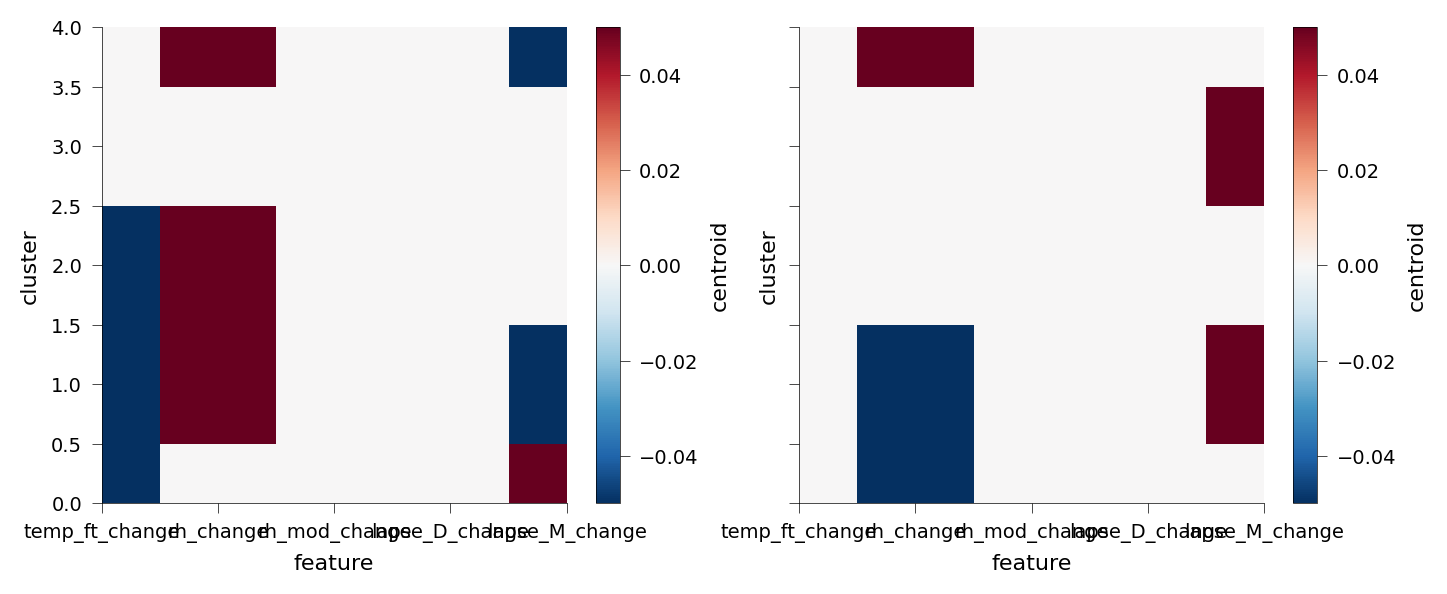

In [191]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col']*1.5)
centroids['ocean'].plot(ax=ax[0])
centroids['land'].plot(ax=ax[1])
plt.show()

In [192]:
desired_order = {'ocean': [3, 0, 2, 1, 4], 'land': [2, 0, 1, 3, 4]}  # order in legend
# Colormap in the order you want to show
colors_cluster = {'ocean': ['springgreen', 'C1', 'green', 'lightgray', 'C3'],
                  'land': ['C0', 'green', 'lightgray', 'C1', 'C3']}
label_segments = {
    'ocean':  [
    [('$T_{FT}$', 'blue'), ('$\eta_M$', 'C3')],
    [('$T_{FT} \eta_M$', 'blue'), ('$r_s$', 'C3')],
    [('$T_{FT}$', 'blue'), ('$r_s$', 'C3')],
    [],
    [('$\eta_M$', 'blue'), ('$r_s$', 'C3')]],
    'land': [
        [('$r_s$', 'blue')],
        [('$r_s$', 'blue'), ('$\eta_M$', 'C3')],
        [],
        [('$\eta_M$', 'C3')],
        [('$r_s$', 'C3')]
    ]}
# desired_order = np.arange(len(n_labels))
# colors_cluster = colors_cluster[:len(n_labels)]
# label_segments = label_segments[:len(n_labels)]

In [193]:
import matplotlib.colors as mcolors
from matplotlib.offsetbox import TextArea, HPacker, AnnotationBbox
# After you made the plot and have the colorbar:
def cbar_multi_color_labels(cbar, label_segments, y_offset=0.3):
    # Function to write colorbar lables in more than one color
    # cbar = m.colorbar
    axc = cbar.ax
    K = len(label_segments)
    ticks = np.arange(K)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([""] * K)  # hide default tick labels
    cbar.ax.tick_params(which="both", length=0)

    # label_segments[cid] = [("hi ", "red"), ("bye", "blue")]
    for i in range(len(label_segments)):
        segs = label_segments[i]

        # Build multi-colored, single-line label
        children = [
            TextArea(txt, textprops=dict(color=col, va="center"))
            for (txt, col) in segs
        ]
        hbox = HPacker(children=children, align="center", pad=0, sep=0)  # pack inline [web:97]

        # Place it at (x,y) in "y in data, x in axes fraction"
        ab = AnnotationBbox(
            hbox,
            (1.3, i),  # just right of the colorbar
            xycoords=axc.get_yaxis_transform(),  # x in axes, y in data coords
            box_alignment=(0.0, y_offset),
            frameon=False,
            pad=0.0,
            clip_on=False,
        )
        axc.add_artist(ab)
    return None

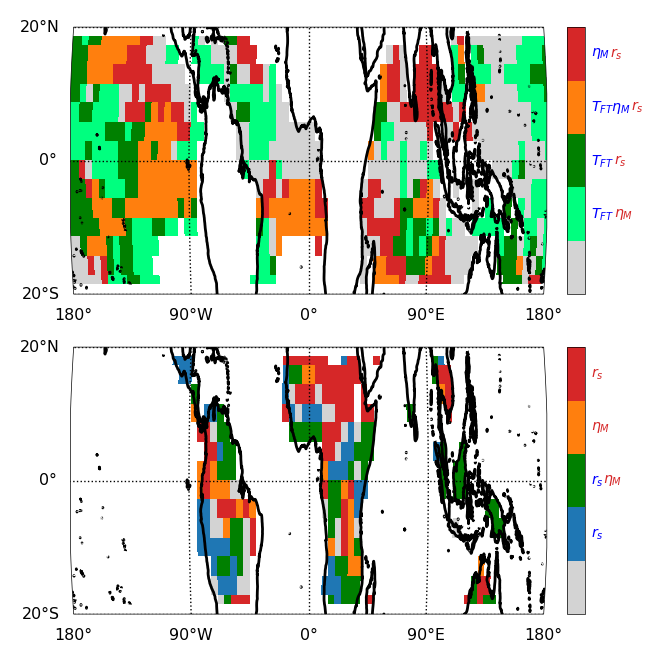

In [194]:
# desired_order: cluster ids in the order you want shown on the colorbar
K = {key: len(desired_order[key]) for key in labels}

# Build mapping: original cluster id -> plotting code 0..K-1
id_to_code = {key: {cid: i for i, cid in enumerate(desired_order[key])} for key in labels}

# Remap the DataArray (vectorized via NumPy indexing)
labels_code = {}
for key in labels:
    max_id = int(labels[key].max())
    lut = np.full(max_id + 1, -1, dtype=int)  # -1 for "unknown" (optional)
    for cid, code in id_to_code[key].items():
        lut[cid] = code

    labels_code[key] = xr.apply_ufunc(
        lambda x: lut[x],
        labels[key].astype(int),
        dask="allowed",
        output_dtypes=[int],
    )

# Colormap in desired order
cmap = {key: mcolors.ListedColormap([colors_cluster[key][cid] for cid in desired_order[key]], name="clusters") for key in labels}
bounds = {key: np.arange(-0.5, K[key] + 0.5, 1) for key in labels}  # monotonic edges
norm = {key: mcolors.BoundaryNorm(bounds[key], cmap[key].N) for key in labels}  # discrete mapping [web:41]
# gl_fontsize = 6

fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
fig_resize(fig, width['one_col'], ar=2)
for i in range(len(ax)):
    gl = utils.initialize_ax_projection(ax[i], lat_min=-20.01, lat_max=20.01, auto_aspect=True,
                                            grid_lat=[-20, 0, 20],
                                            grid_lon=[-180, -90, 0, 90, 180], return_gl=True, gridline_lw=0.5)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
mask_use = {'ocean': mask_loc & mask_loc_ocean, 'land': mask_loc & mask_loc_land}
for i, key in enumerate(labels):
    im = utils.plot_contour_projection(ax[i], labels_code[key].where(mask_use[key]), imshow=True, cmap=cmap[key],
                                       imshow_kwargs={'norm': norm[key], 'aspect': 'auto',
                                                      'extent': (0, 360, -20, 20), 'interpolation': 'none'})
    cbar = plt.colorbar(im, ax=ax[i], ticks=np.arange(K[key]), pad=0.01, shrink=1, aspect=15)

    cbar_multi_color_labels(cbar, [label_segments[key][i] for i in desired_order[key]])
    cbar.set_label('')
# Custom tick labels (cluster names) [web:47]
# cbar = m.colorbar
# cbar.set_ticklabels([name_dict[cid] for cid in desired_order])

# Indicate where NL terms are important - only NL terms involving a change mechanism, anom only nl dealt with in previous plot
# plot_scatter_mask(mask_nl, ax, s=5)
# ax.set_title("Clusters")
update_fontsize(fig, base_fontsize=6)
# savefig(fig)
plt.show()

### Decomposing FT Response
Idea is that in tropics expect the free tropospheric temperature to be zonally uniform. Here plot deviation of temperature at given location from zonal mean at time when occured. It is the change in this anomaly that dominates the overall free tropospheric temperature change.

In the next plot, we breakdown the change in this free tropospheric temperature anomaly, finding that with warming the hottest 50% and hottest 95% of days become more similar in terms of this metric.

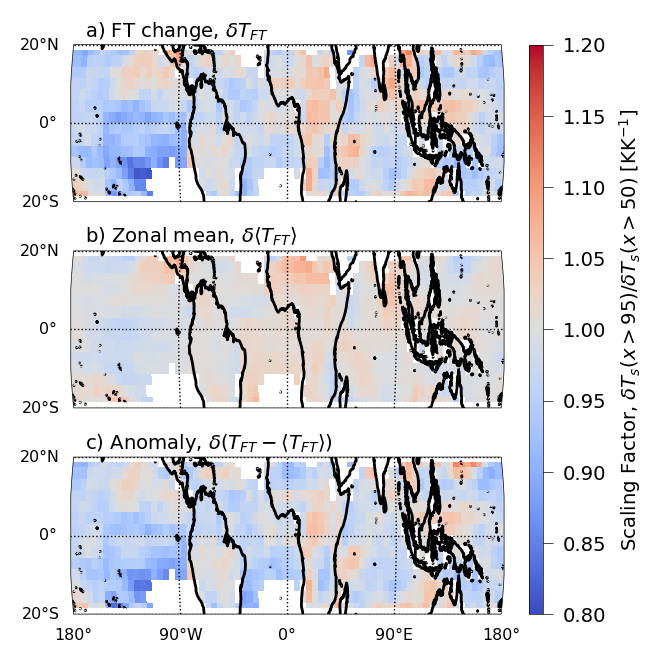

In [202]:
temp_ft_zm_sf_cont = ds_sf.temp_ft_change / ds_av.T_ft_env.diff(dim='co2') * ds_av.T_ft_env_zm.diff(dim='co2')
temp_ft_anom_sf_cont = ds_sf.temp_ft_change / ds_av.T_ft_env.diff(dim='co2') * ds_av.T_ft_env_anom.diff(dim='co2')

fig = plt.figure(constrained_layout=True)
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})
fig_resize(fig, width['one_col'], ar=3)
for i in range(len(ax)):
    gl = utils.initialize_ax_projection(ax[i], lat_min=-20.01, lat_max=20.01, auto_aspect=True,
                                            grid_lat=[-20, 0, 20],
                                            grid_lon=[-180, -90, 0, 90, 180], return_gl=True, gridline_lw=0.5)[1]
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}
    if i < 2:
        gl.bottom_labels = False

im = utils.plot_contour_projection(ax.flatten()[0], ds_sf.temp_ft_change.diff(dim='quant').squeeze().where(mask_loc)+1,
                                   cmap='coolwarm', imshow=True,
                                   imshow_kwargs={'vmin': 0.8, 'vmax': 1.2, 'aspect': 'auto',
                                                  'extent': (0, 360, -20, 20)})

im = utils.plot_contour_projection(ax.flatten()[1], temp_ft_zm_sf_cont.diff(dim='quant').squeeze().where(mask_loc)+1,
                                   cmap='coolwarm', imshow=True,
                                   imshow_kwargs={'vmin': 0.8, 'vmax': 1.2, 'aspect': 'auto',
                                                  'extent': (0, 360, -20, 20)})
im = utils.plot_contour_projection(ax.flatten()[2], temp_ft_anom_sf_cont.diff(dim='quant').squeeze().where(mask_loc)+1,
                                   cmap='coolwarm', imshow=True,
                                   imshow_kwargs={'vmin': 0.8, 'vmax': 1.2, 'aspect': 'auto',
                                                  'extent': (0, 360, -20, 20)})
plt.colorbar(im, ax=ax.flatten().ravel(), label=sf_label, pad=0.02, fraction=0.1, aspect=40)
label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=9,
               labels=[f"a) {utils.labels_cont['temp_ft_change']}"+", $\delta T_{FT}$",
                       "b) Zonal mean, $\delta \langle T_{FT}\\rangle$",
                       "c) Anomaly, $\delta \left(T_{FT} - \langle T_{FT}\\rangle\\right)$"])
update_fontsize(fig)
plt.show()
# savefig(fig)

Fraction points similar | CO2x1 | 0.46223224351747466
Mean anomaly | quant50 | CO2x1 | 1.0176067 0.84055996
Fraction points similar | CO2x2 | 0.7147688838782412
Mean anomaly | quant50 | CO2x2 | 0.9388661 0.7765053
Mean anomaly | quant95 | CO2x1 | 1.0658797 0.8553345
Mean anomaly | quant95 | CO2x2 | 0.97939646 0.7980905


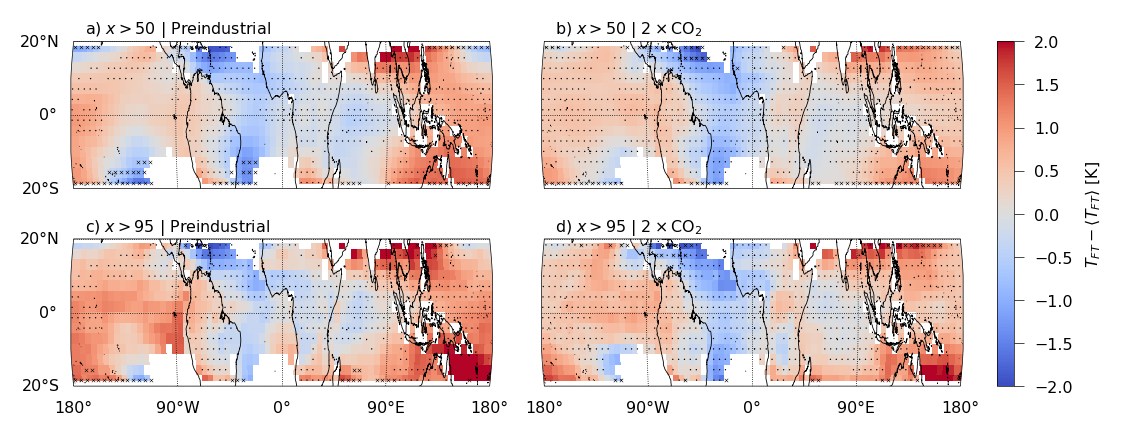

In [226]:
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0.1, 'wspace': 0})
# fig_resize(fig, 10, ar=5)
fig_resize(fig, width['two_col'])
for i in range(len(ax.flatten())):
    # Aspect='auto crucial to keep axes looking good throughout
    gl = utils.initialize_ax_projection(ax.flatten()[i], lat_min=-20.01, lat_max=20.01, auto_aspect=True,
                                        gridline_lw=0.3, coastline_lw=0.3, grid_lat=[-20, 0, 20],
                                        grid_lon=[-180, -90, 0, 90, 180], return_gl=True)[1]
    if i < 2:
        gl.bottom_labels = False
    if i % 2:
        gl.left_labels = False
    gl.xlabel_style = {"size": gl_fontsize}
    gl.ylabel_style = {"size": gl_fontsize}


for i in range(ds_av.quant.size):
    for j in range(ds_av.co2.size):
        im = utils.plot_contour_projection(ax[i, j], ds_av.T_ft_env_anom.isel(quant=i, co2=j).where(mask_loc), cmap='coolwarm',
                                           imshow=True, imshow_kwargs={'vmin': -2, 'vmax': 2, 'aspect': 'auto',
                                                                       'extent': (0, 360, -20, 20)})
        mask_use = np.abs(ds_av.T_ft_env_anom.isel(co2=j).diff(dim='quant').squeeze().where(mask_loc))<0.25
        plot_scatter_mask(np.abs(ds_av.T_ft_env_anom.isel(co2=j).diff(dim='quant').squeeze().where(mask_loc))<0.25, ax[i, j],
                          marker='.', linewidths=0.1, s=1)
        # print(np.abs(ds_av.T_ft_env_anom.isel(quant=i, co2=j).where(mask_loc)).mean())
        if i==0:
            # Fraction of grid points which are similar7
            print(f'Fraction points similar | CO2x{j+1} |',float((mask_use.sum()/mask_loc.sum()).values))
        # Shade which regions have large standard deviation (unexpected in tropics) of this anomaly
        # Show most are at high latitudes. Also comment that very negative x=50 regions have large standard deviation
        key = f'quant{[50, 95][i]}'
        # Only consider valid days at each point
        mask_use = (ds_coarse[key]['mask_conv_land'] & mask_loc_land) | (ds_coarse[key]['mask_conv_ocean'] & mask_loc_ocean)
        var = ds_coarse[key].T_ft_env_anom.where(mask_use).isel(co2=j)
        plot_scatter_mask(var.weighted(ds_coarse[key].lat_weights).std(dim='sample').where(mask_loc)>1.5, ax[i, j],
                          marker='x', linewidths=0.2, s=1.5)
        #
        print(f'Mean anomaly | {key} | CO2x{j+1} |', np.abs(var).weighted(ds_coarse[key].lat_weights).mean(dim=['sample', 'lat', 'lon']).values,
              np.abs(var).weighted(ds_coarse[key].lat_weights).std(dim=['sample', 'lat', 'lon']).values)

plt.colorbar(im, ax=ax.flatten().ravel(), label="$T_{FT} - \langle T_{FT} \\rangle$ [K]", pad=0.02)
label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=8,
               labels=[f'a) $x>50$ | Preindustrial', f'b) $x>50$ | $2\\times$CO$_2$',
                       f'c) $x>95$ | Preindustrial', f'd) $x>95$ | $2\\times$CO$_2$'])
update_fontsize(fig)
plt.show()
# savefig(fig)